In [166]:
import data_processing
import matplotlib.pyplot as plt

features, labels = data_processing.read_train_dataset()

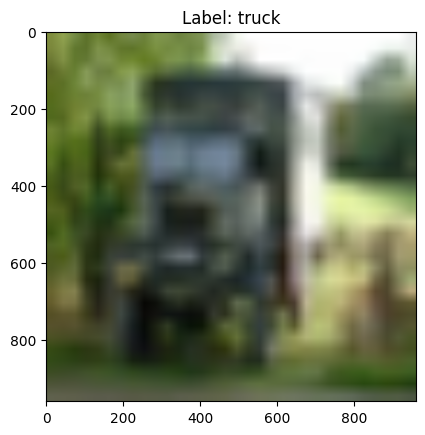

<Figure size 500x500 with 0 Axes>

In [167]:
import cv2

img, label = data_processing.sample_one_img(features, labels)
img2 = cv2.resize(img, (960, 960))

plt.imshow(img2)
plt.title(f'Label: {data_processing.get_class_names()[label]}')
plt.figure(figsize=(5, 5))
plt.show()

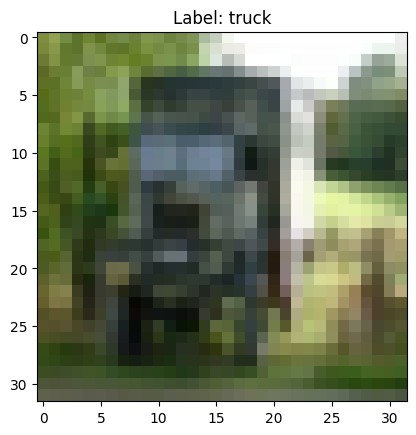

<Figure size 500x500 with 0 Axes>

In [168]:
plt.imshow(img)
plt.title(f'Label: {data_processing.get_class_names()[label]}')
plt.figure(figsize=(5, 5))
plt.show()

In [178]:
import math
from einops import repeat
import torch.nn.functional as F
from torch import arange, randn, tensor, log, multinomial

def nce_loss(logits_pos, logits_neg, log_pn_pos, log_pn_neg, k):
    """Compute the noise contrastive estimation loss in
    https://arxiv.org/abs/1806.03664.

    Params:
        - logits_pos: Tensor. Shape: (bs, 1). Logits corresponding to labels.
        - logits_neg: Tensor. Shape: (bs * k, 1). Logits corresponding to sampled classes.
        - log_pn_pos: Tensor. Shape: (bs, 1). Log-probability of labels sampled from noise distribution.
        - log_pn_neg: Tensor. Shape: (bs * k, 1). Log-probability of noise candidates sampled from noise distribution.
        - k: int. The number of noise candidates per training example.

    Note:
        This implementation assumes each context is equally shown which leads to final averge."""

    logk = math.log(k)
    # For numerical stability, replace logsigmoid by the torch softplus
    # for it considers the overflow situation.
    # log(sigmoid(x)) = -softplus(-x)
    # final return also contains minus(-), thus remove all the minus(-)
    pos = F.softplus((logk + log_pn_pos) - logits_pos).mean()
    neg = F.softplus(logits_neg - (logk + log_pn_neg)).mean()
    return pos + neg


def log_uniform(num_sampled, range_max, replacement=True):
    """Sample classes from log-uniform distribution.:
    p(class) = (log(class + 2) - log(class + 1)) / (log(range_max + 1)).
    sampled_classes: [0, range_max).

    Also note that the data distribution should follow the log_uniform.
    e.g., the classes should be in decreasing order of frequencey when in text generation.

    Params:
        - num_sampled: int. The number to be sampled.
        - range_max: int. The number of total classes.
        - replacement: bool. If false, sampled candidates are unique.

    Examples:
        >>> log_uniform(2, 10)
        >>> # tensor([7, 2])
    """
    classes = arange(0, range_max)
    probs = log((classes + 2) / (classes + 1)) / math.log(range_max + 1)
    return probs, multinomial(probs, num_sampled, replacement=replacement)


def main():
    bs, k = 2, 4
    num_classes = 8

    logits = randn(bs, num_classes)
    labels = tensor([2, 4])
    probs, noise_classes = log_uniform(bs * k, num_classes)
    logits_pos = logits.take_along_dim(labels[:, None], dim=1)
    log_pn_pos = probs[labels]
    log_pn_neg = probs[noise_classes]
    logits_k = repeat(logits, '(b 1) h -> (b k) h', k=k)
    logits_neg = logits_k.take_along_dim(noise_classes.reshape(bs * k, -1), dim=1)

    loss = nce_loss(logits_pos, logits_neg, log_pn_pos, log_pn_neg, k)
    # logits_pos : 正样本在 正样本D 的logits
    # logits_neg : 负样本在 正样本D 的logits
    # log_pn_pos : 正样本在 噪声D 的logits
    # log_pn_neg : 负样本在 噪声D 的logits    
    print('nce loss: %f' %loss)

if __name__ == '__main__':
    main()


RuntimeError: shape '[2, 1]' is invalid for input of size 8

In [174]:
import torch
from torch import nn
from torch.nn import functional as F

# NCE loss
bs, k = 2, 4
num_classes = 8

logits = randn(bs, num_classes)
labels = tensor([2, 4])
probs, noise_classes = log_uniform(bs * k, num_classes)
logits_pos = logits.take_along_dim(labels[:, None], dim=1)
log_pn_pos = probs[labels]
log_pn_neg = probs[noise_classes]
logits_k = repeat(logits, '(b 1) h -> (b k) h', k=k)
logits_neg = logits_k.take_along_dim(noise_classes.reshape(bs * k, -1), dim=1)

print('nce loss: %f' % loss)

AttributeError: module 'torch.nn.functional' has no attribute 'nce_loss'